<a href="https://colab.research.google.com/github/ches-zac/skripsi_disleksia_ML/blob/main/Copy_of_Skripsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Persiapan library

In [ ]:
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import pickle
import math
import seaborn as sns
import json
import gc
import joblib
from google.colab import drive
from glob import glob
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from tensorflow import keras
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import clone_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers
from keras import backend as k
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions

!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.6
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.0.1
astropy-iers-data                     0.2025.4.28.0.37.27
astunparse                            1.6.3
atpublic                              5

In [ ]:
# Persiapan tensorflow
# Mengaktifkan pertumbuhan memori untuk GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Pertumbunan memori GPU diaktifkan")
    except RuntimeError as e:
        print(e)

tf.config.run_functions_eagerly(True)  # Mengaktifkan eager execution
tf.config.optimizer.set_jit(True)  # Mengaktifkan XLA Compilation
tf.data.experimental.enable_debug_mode() # Mengaktifkan debug mode untuk tf.data

In [ ]:
# Persiapan path data
# Mount google drive
drive.mount('/content/drive')

# Path data asli
data_ori_dir = "/content/drive/MyDrive/skripsi/handwriting_images"
# Path dataset hasil preprocessing
dataset_dir = "/content/drive/MyDrive/skripsi/preprocessed_datasets"
# Path hasil pelatihan dengan k-fold cv
kfold_dir = "/content/drive/MyDrive/skripsi/kfold_results"

Mounted at /content/drive


Pendefinisian Fungsi-Fungsi

In [ ]:
# Mendefinisikan pipeline augmentsi
augmentation_pipeline = A.Compose([
    A.Rotate(limit=6),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2),
])

# Mendefinisikan resizing pipeline
def resizing_pipeline(image, target_size=(200, 200)):
    h, w = image.shape[:2]
    aspect_ratio = w / h  # Rasio aspek dari gambar asli
    if 0.9 <= aspect_ratio <= 1.1: # jika rasio aspek adalah sekitar 1:1 maka menggunakan resize langsung
        resized = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
        return resized
    else: # Jika tidak, maka resize dengan padding dan mempertahankan rasio aspek
        scale = min(target_size[0] / h, target_size[1] / w)
        new_w, new_h = int(w * scale), int(h * scale)
        # Resize gambar
        if w > target_size[0] or h > target_size[1]:
            resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)  # Pengecilan
        else:
            resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)  # Pembesaran
        # Hitung padding
        pad_top = (target_size[1] - new_h) // 2
        pad_bottom = target_size[1] - new_h - pad_top
        pad_left = (target_size[0] - new_w) // 2
        pad_right = target_size[0] - new_w - pad_left
        # Tambahkan padding dengan warna putih
        if len(image.shape) == 2:  # Memastikan gambar adalah grayscale
            padded = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right,
                                        cv2.BORDER_CONSTANT, value=255)
        else:  # Jika gambar dalam format RGB
            padded = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right,
                                        cv2.BORDER_CONSTANT, value=(255, 255, 255))
        return padded

# Mendefinisikan pipeline preprocessing
def preprocess_image(image_path, target_size=(200, 200),blockSize=25, c=8, b=5, augment=False):
    # Redacted
    return image

# Mendefinisikan fungsi load_dataset
def load_dataset(data_dir, target_size=(200, 200), blockSize=25, c=8, b=5, augmenting=True, num_augmented=2):
    images = []
    labels = []
    for label, category in enumerate(["dyslexic", "non_dyslexic"]):
        category_dir = os.path.join(data_dir, category)
        image_names = os.listdir(category_dir)
        print(f"Loading {len(image_names)} images from {category} (label = {label})")
        for image_name in image_names:
            image_path = os.path.join(category_dir, image_name)
            # Preprocess gambar asli
            original_image = preprocess_image(image_path, target_size, blockSize, c, b, augment=False)
            images.append(original_image) # Tambah gambar ke dataset
            labels.append(label) # Tambah label ke dataset
            # Augmentasi gambar
            if augmenting:
                for _ in range(num_augmented): # Jumlah proses augmentasi pada 1 gambar
                    augmented_image = preprocess_image(image_path, target_size, blockSize, c, b, augment=True)
                    images.append(augmented_image) # Tambah gambar augmentasi ke dataset
                    labels.append(label) # Tambah label ke dataset
    # Mengubah dataset ke Numpy array
    images = np.array(images)
    labels = np.array(labels)
    # Print distribusi kelas
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("Distribusi kelas pada dataset:")
    for cls, count in zip(unique_labels, counts):
        print(f"Kelas {cls}: {count} samples")
    return images, labels

# Mendefinisikan fungsi penyimpanan dataset
def save_dataset(images, labels, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "images.npy"), images)
    np.save(os.path.join(output_dir, "labels.npy"), labels)
    print(f"Dataset saved to {output_dir}")

# Mendefinisikan fungsi load dataset tersimpan
def load_saved_dataset(dataset_dir):
    images = np.load(os.path.join(dataset_dir, "images.npy"))
    labels = np.load(os.path.join(dataset_dir, "labels.npy"))
    return images, labels

# Mendefinisikan fungsi load dataset tersimpan
def load_saved_results(dataset_dir):
    results = np.load(os.path.join(dataset_dir, "results.npy"), allow_pickle=True).item()
    histories = np.load(os.path.join(dataset_dir, "histories.npy"), allow_pickle=True)
    best_model_paths = np.load(os.path.join(dataset_dir, "best_models.npy"), allow_pickle=True)
    return results, histories, best_model_paths

# Menampilkan sampel dataset
def plot_images(images, labels, num_images=6):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

# Mendefinisikan plot hastory pelatihan dan validasi pada setiap fold
def plot_fold_history(histories):
    k = len(histories)  # Jumlah fold
    rows = math.ceil(k / 2)
    cols = min(2, k)  # Maksimal 2 kolom per baris
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()  # Ubah menjadi array 1D
    for i, history_file in enumerate(histories):
        ax1 = axes[i]
        with open(history_file, "r") as f:
            history = json.load(f)
        ax2 = ax1.twinx()
        # Plot training & validation accuracy di sumbu pertama
        acc_train, = ax1.plot(history['accuracy'], label='Train Accuracy', marker='o', color='blue')
        acc_val, = ax1.plot(history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='s', color='dodgerblue')
        # Plot training & validation loss di sumbu kedua
        loss_train, = ax2.plot(history['loss'], label='Train Loss', marker='o', color='red')
        loss_val, = ax2.plot(history['val_loss'], label='Validation Loss', linestyle='--', marker='s', color='tomato')

        ax1.set_title(f'Fold {i + 1}')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy', color='blue')
        ax2.set_ylabel('Loss', color='red')
        ax1.grid(True, linestyle='--', alpha=0.6)
        lines = [acc_train, acc_val, loss_train, loss_val]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, loc='upper right')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

# Mendefinisikan fungsi grafik confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# Mendefinisikan fungsi tf untuk mengurangi tracing berlebiihan
@tf.function(reduce_retracing=True)
def predict_batch(model, X):
    predictions = model.predict(X, batch_size=16)  # Predict in batches
    return predictions

print("✅ Pendefinisian fungsi selesai!")

✅ Pendefinisian fungsi selesai!


Load dataset

Loading 50 images from dyslexic (label = 0)
Loading 50 images from non_dyslexic (label = 1)
Class distribution in loaded dataset:
Class 0: 100 samples
Class 1: 100 samples
Dataset saved to /content/drive/MyDrive/skripsi/preprocessed_datasets/dataset2_1
X shape: (200, 200, 200, 3)
y shape: (200,)


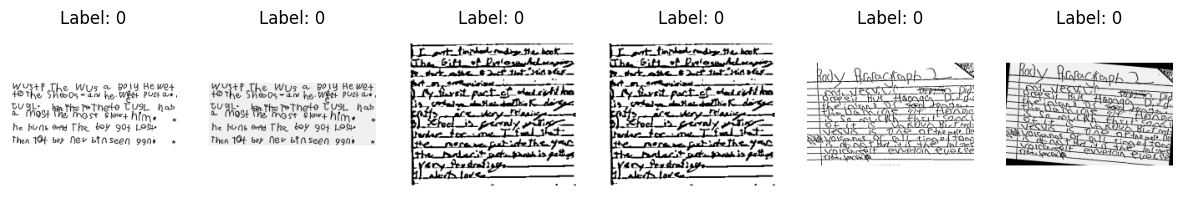

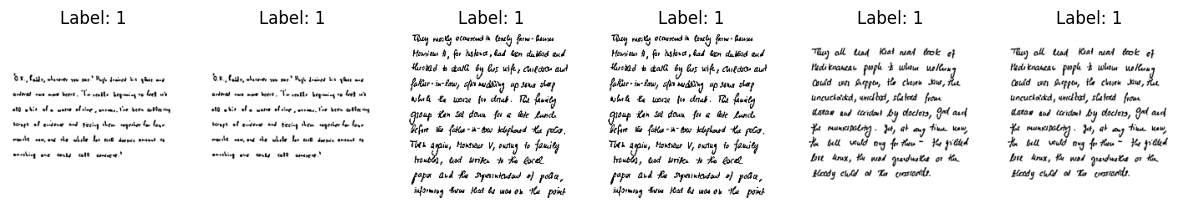

In [ ]:
# Load dan preprocess dataset
X, y = load_dataset(
    data_dir=data_ori_dir,
    augmenting=True,
    num_augmented=1,
    blockSize=25,
    c=8,
    b=5
)

# Simpan dataset
output_dir = os.path.join(dataset_dir, "dataset2_1")
save_dataset(X, y, output_dir)

# Print bentuk dataset
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Visualisasi sampel
plot_images(X[:6], y[:6])
plot_images(X[100:106], y[100:106])

Inisialisasi dan persiapan model densenet serta kfold cross validation

In [ ]:
# Preparasi dan Inisialisasi model densenet
def build_densenet(input_shape=(200, 200, 3), num_classes=1):
    base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    # Redacted
    return model

# Pendefinisian pipeline K-fold
def run_kfold_cv(X_train, y_train, output_dir, n_splits=4, epochs=15, batch_size=16):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {"accuracy": [], "precision": [], "recall": [], "f1": []}
    histories = []
    best_model_paths = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        print(f"Fold {fold + 1}")
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Pemanggilan model
        model = build_densenet()
        # Redacted
        model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

        # Pendefinisian checkpoint untuk menyimpan model terbaik di seluruh fold
        model_path = os.path.join(output_dir, f"best_model_fold{fold + 1}.keras")
        checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max')

        # Latih model
        history = model.fit(
            X_train_fold, y_train_fold,
            epochs=epochs, batch_size=batch_size,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[checkpoint]
        )

        # Simpan riwayat pelatihan
        history_dict = {key: val for key, val in history.history.items()}
        history_file = os.path.join(output_dir, f"history_fold{fold + 1}.json")
        os.makedirs(os.path.dirname(history_file), exist_ok=True)
        with open(history_file, "w") as f:
            json.dump(history_dict, f)
        histories.append(history_file)

        # Load model terbaik
        best_model = tf.keras.models.load_model(model_path)
        best_model_paths.append(model_path)  # simpan path model untuk penggunaan selanjutnya

        # Validasi model
        y_pred = predict_batch(best_model, X_val_fold)
        y_pred_classes = (y_pred > 0.5).astype(int)
        y_true_classes = y_val_fold

        # Simpan hasil validasi model
        results["accuracy"].append(accuracy_score(y_true_classes, y_pred_classes))
        results["precision"].append(precision_score(y_true_classes, y_pred_classes))
        results["recall"].append(recall_score(y_true_classes, y_pred_classes))
        results["f1"].append(f1_score(y_true_classes, y_pred_classes))

        all_y_true.extend(y_true_classes)
        all_y_pred.extend(y_pred_classes)

        # Clear RAM
        del model, history, X_train_fold, X_val_fold, y_train_fold, y_val_fold
        gc.collect()
        tf.keras.backend.clear_session()

    # Simpan hasil
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "results.npy"), results)
    np.save(os.path.join(output_dir, "histories.npy"), histories)
    np.save(os.path.join(output_dir, "best_models.npy"), best_model_paths)
    return results, histories, best_model_paths


Load dan split dataset

distribusi kelas sebelum splitting: (array([0, 1]), array([100, 100]))
distribusi kelas setelah splitting:
y_train shape: (140,)
y_test shape: (60,)

Distribusi kelas data latih (%):
{np.int64(0): np.float64(50.0), np.int64(1): np.float64(50.0)}

Distribusi kelas data uji (%):
{np.int64(0): np.float64(50.0), np.int64(1): np.float64(50.0)}


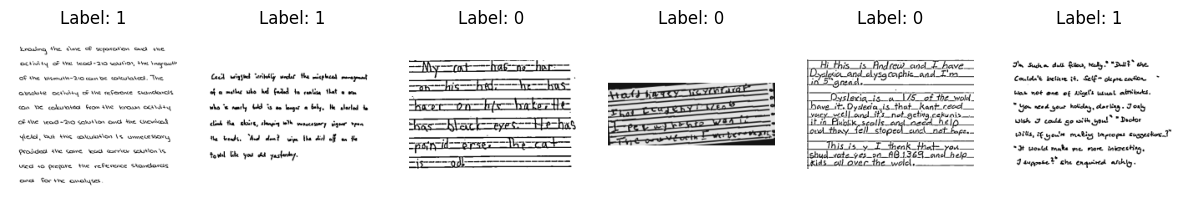

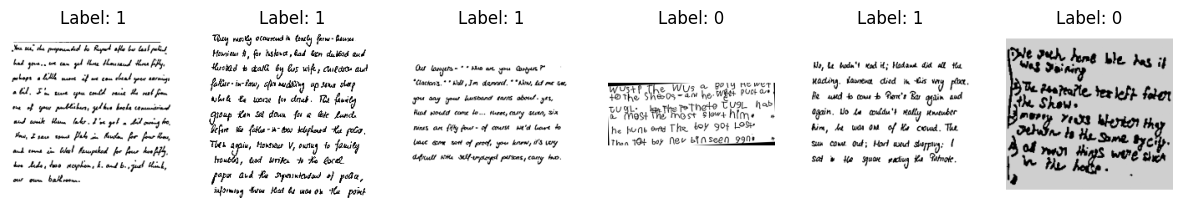

In [ ]:
dataset_path = os.path.join(dataset_dir, "dataset2")
X, y = load_saved_dataset(dataset_path)

# Split dataset menjadi data uji dan data latih
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Memeriksa distribusi kelas
print("distribusi kelas sebelum splitting:", np.unique(y, return_counts=True))
print("distribusi kelas setelah splitting:")
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# kalkulasi dan menampilkan distribusi kelas pada data latih dan uji
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
print("\nDistribusi kelas data latih (%):")
print({cls: (count / len(y_train)) * 100 for cls, count in zip(train_classes, train_counts)})
print("\nDistribusi kelas data uji (%):")
print({cls: (count / len(y_test)) * 100 for cls, count in zip(test_classes, test_counts)})
plot_images(X_train[80:86], y_train[80:86])
plot_images(X_test[20:26], y_test[20:26])

Pelatihan model

In [ ]:
print(f"Pelatihan dataset2 :")

# Menjalankan k-fold CV pada dataset
output_dir = os.path.join(kfold_dir, "dataset2_xx6_30_1")
results, histories, best_model_paths = run_kfold_cv(X_train, y_train, output_dir)


Pelatihan dataset2 :
Fold 1
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 84s 12s/step - accuracy: 0.6178 - loss: 0.9628 - val_accuracy: 0.3714 - val_loss: 1.0980
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 89s 13s/step - accuracy: 0.5510 - loss: 1.0585 - val_accuracy: 0.4857 - val_loss: 1.0207
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 10s/step - accuracy: 0.7413 - loss: 0.8453 - val_accuracy: 0.6000 - val_loss: 0.9540
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 10s/step - accuracy: 0.6683 - loss: 0.9157 - val_accuracy: 0.6857 - val_loss: 0.8952
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.7102 - loss: 0.8321 - val_accuracy: 0.8000 - val_loss: 0.8470
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 9s/step - accuracy: 0.7726 - loss: 0.7605 - val_accuracy: 0.9143 - val_loss: 0.8066
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.7917 - loss: 0.7375 - val_accuracy: 0.9429 - val_loss: 0.7709
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 9s/step -

Hasil latihan dengan dataset2:
Accuracy: 0.9286 ± 0.0319
Precision: 0.8901 ± 0.0801
Recall: 0.9833 ± 0.0289
F1: 0.9313 ± 0.0349



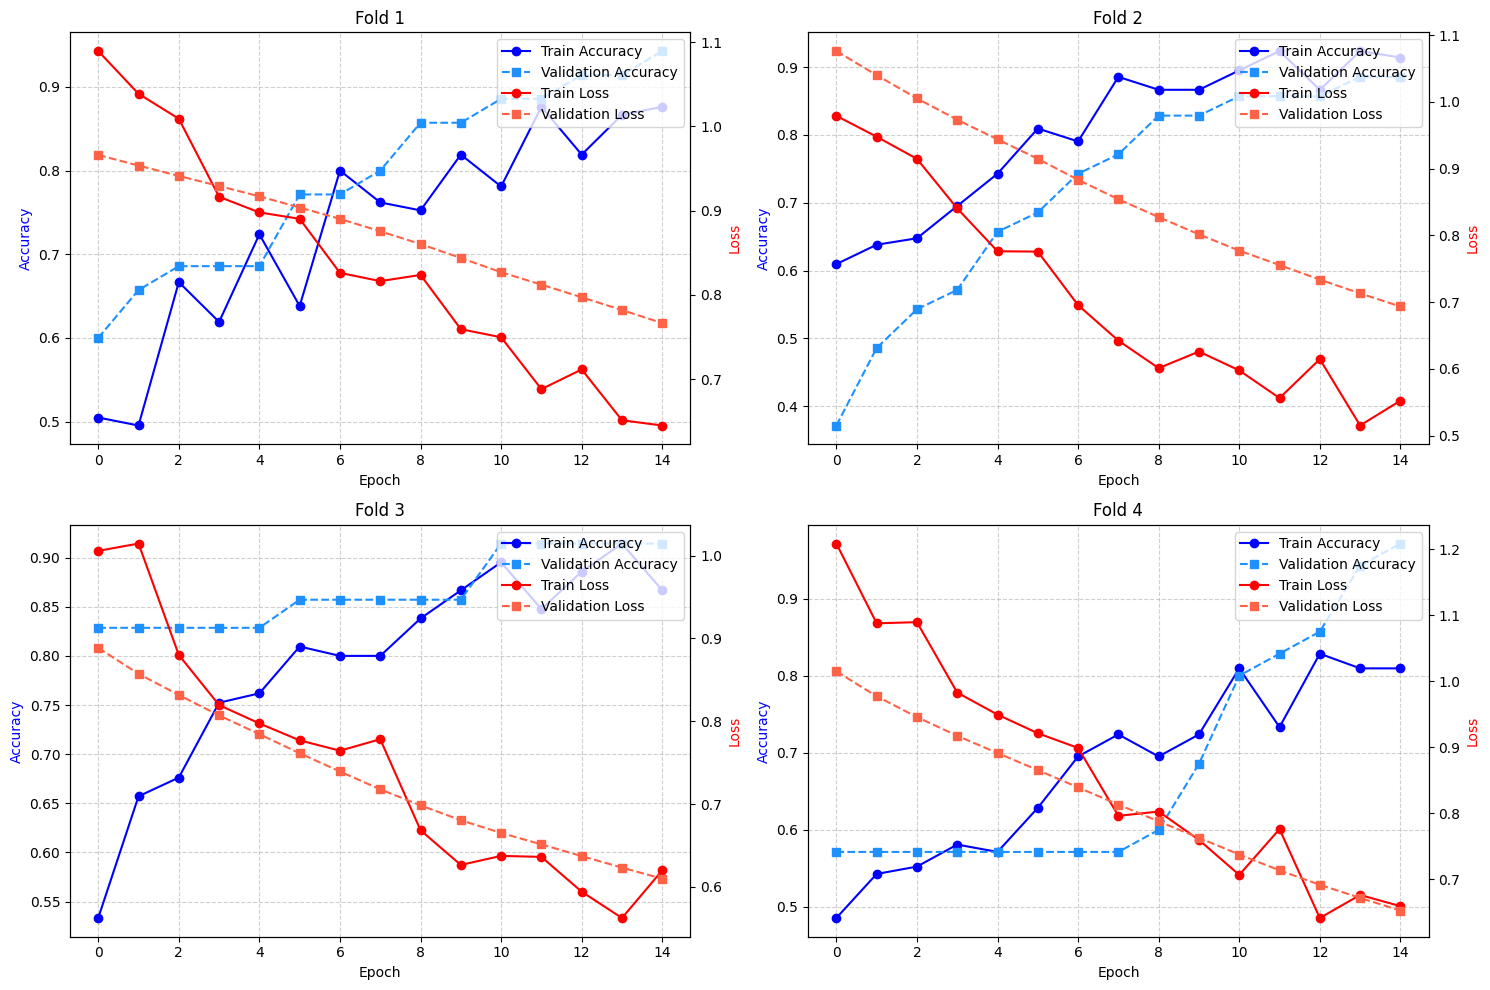

In [ ]:
train_results_dir = os.path.join(kfold_dir, "dataset2_xx6_30_versi no reduce lr and early stopping")
results, histories, best_model_paths = load_saved_results(train_results_dir)

# Print hasil akurasi latihan dari keseluruhan k-fold cv
print(f"Hasil latihan dengan dataset2:")
for metric, values in results.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")
print()

# Grafik pelatihan pada setiap fold dalam k=fold
plot_fold_history(histories)

Pengujian model

Loaded best model from: /content/drive/MyDrive/skripsi/kfold_results/dataset2_xx6_30_versi no reduce lr and early stopping/best_model_fold4.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step

Test Set Metrics:
Accuracy: 0.9
Precision: 1.0
Recall: 0.8
F1-Score: 0.8888888888888888


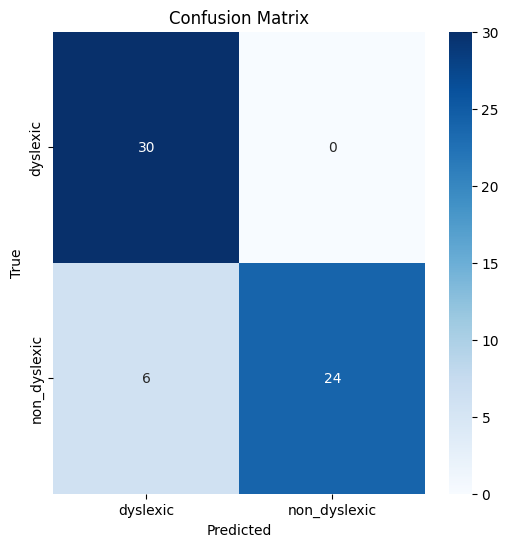

In [ ]:
# Mengambil model dengan performa terbaik
final_model_path = best_model_paths[np.argmax(results["accuracy"])]
final_model = tf.keras.models.load_model(final_model_path)
print(f"Loaded best model from: {final_model_path}")

# kompilasi model dengan optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
final_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Pengujian model
test_predictions = predict_batch(final_model, X_test)
test_predictions_classes = (test_predictions > 0.5).astype(int)
test_true_classes = y_test

# Kalkulasi hasil pengujian model
test_accuracy = accuracy_score(test_true_classes, test_predictions_classes)
test_precision = precision_score(test_true_classes, test_predictions_classes)
test_recall = recall_score(test_true_classes, test_predictions_classes)
test_f1 = f1_score(test_true_classes, test_predictions_classes)

# Print metrik evaluasi
print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1-Score: {test_f1}")

# Plot confusion matrix
plot_confusion_matrix(test_true_classes, test_predictions_classes, class_names=["dyslexic", "non_dyslexic"])

Demonstrasi klasifikasi gambar individu dengan CNN (DenseNet)

Processed image shape: (1, 200, 200, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Raw model output: [[0.09865727]]
Predicted Class: Dyslexic
Confidence: 9.87%


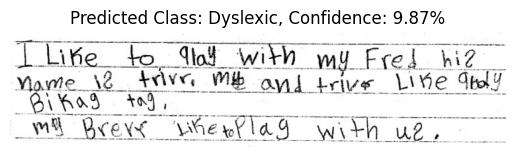

In [ ]:
# Load model yang telah dilatih
final_model_path = best_model_paths[np.argmax(results["accuracy"])]  # Get best model based on accuracy
final_model = tf.keras.models.load_model(final_model_path)  # Load it

# Fungsi untuk melakukan prediksi
def predict_image_class(img_path, model):
    # Preprocess gambar
    processed_img = preprocess_image(img_path, target_size=(200, 200), blockSize=25, c=8, b=5, augment=False)
    # Pastikan bentuk input benar
    if len(processed_img.shape) == 3:
        processed_img = np.expand_dims(processed_img, axis=0)
    print(f"Processed image shape: {processed_img.shape}")

    # Lakukan prediksi
    predictions = model.predict(processed_img)
    print(f"Raw model output: {predictions}")
    predicted_class = 1 if predictions[0, 0] > 0.5 else 0

    # Ubah label numerik menjadi label deskriptif
    class_labels = {0: "Dyslexic", 1: "Non-Dyslexic"}
    predicted_label = class_labels[predicted_class]
    return predicted_label, predictions[0, 0] if predictions.shape[1] == 1 else np.max(predictions)


if __name__ == "__main__":
    # Path ke gambar yang akan diklasifikasi
    img_path = # Redacted
    # img_path = "/content/a01-020.png"

    # Lakukan klasifikasi
    predicted_label, confidence = predict_image_class(img_path, final_model)

    # Tampilkan hasil klasifikasi
    print(f"Predicted Class: {predicted_label}")
    print(f"Confidence: {confidence * 100:.2f}%")

    # Tampilkan gambar
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_label}, Confidence: {confidence * 100:.2f}%")
    plt.axis('off')
    plt.show()

In [ ]:
# Jika ingin melihat confidence score seluruh gambar dalam 1 kelas
if __name__ == "__main__":
    folder_path = "/content/drive/MyDrive/skripsi/handwriting_images/dyslexic/"
    image_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    print(f"{'Image':<15} | {'Predicted Class':<15} | {'Confidence (%)':<15}")
    print("-" * 50)

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        predicted_label, confidence = predict_image_class(img_path, final_model)
        print(f"{img_file:<15} | {predicted_label:<15} | {confidence * 100:.2f}%", end="\n\n")

Metode baseline dengan Random Forest

In [ ]:
# Path penyimpanan hasil random forest
rf_results_dir = os.path.join(kfold_dir, "dataset2_xx6_30")
os.makedirs(rf_results_dir, exist_ok=True)

# Pendefinisian Kfold cv
kf = KFold(n_splits=4, shuffle=True, random_state=42)
results = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}")

    # Split data latih menjadi data latih dan data validasi
    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

    # Preprocessing data untuk model random forest
    # Flatten
    X_train_flattened = X_train_fold.reshape(X_train_fold.shape[0], -1)
    X_test_flattened = X_test_fold.reshape(X_test_fold.shape[0], -1)
    # PCA
    pca = PCA(n_components=100)  # kurangi hingga menjadi 100 fitur
    X_train_pca = pca.fit_transform(X_train_flattened)
    X_test_pca = pca.transform(X_test_flattened)

    n_trees_range = range(1, 101)  # jumlah pohon
    for n_trees in n_trees_range:
        # Inisialisasi model random forest
        rf_model = RandomForestClassifier(
            n_estimators=n_trees,
            max_depth=10,
            min_samples_leaf=2,
            random_state=42,
        )
        # Latih model Random Forest
        rf_model.fit(X_train_pca, y_train_fold)
    # Simpan model
    model_filename = os.path.join(rf_results_dir, f"random_forest_fold{fold + 1}.joblib")
    joblib.dump(rf_model, model_filename)
    print(f"Model saved: {model_filename}")
    # Evaluasi
    y_pred = rf_model.predict(X_test_pca)
    # Kalkulasi metrik evaluasi
    results["accuracy"].append(accuracy_score(y_test_fold, y_pred))
    results["precision"].append(precision_score(y_test_fold, y_pred))
    results["recall"].append(recall_score(y_test_fold, y_pred))
    results["f1"].append(f1_score(y_test_fold, y_pred))

# Simpan hasil
np.save(os.path.join(rf_results_dir, "results_rf.npy"), results)

Fold 1
Model saved: /content/drive/MyDrive/skripsi/kfold_results/dataset2_xx6_30/random_forest_fold1.joblib
Fold 2
Model saved: /content/drive/MyDrive/skripsi/kfold_results/dataset2_xx6_30/random_forest_fold2.joblib
Fold 3
Model saved: /content/drive/MyDrive/skripsi/kfold_results/dataset2_xx6_30/random_forest_fold3.joblib
Fold 4
Model saved: /content/drive/MyDrive/skripsi/kfold_results/dataset2_xx6_30/random_forest_fold4.joblib

Final K-Fold Cross Validation Results:
Accuracy: 0.8357 ± 0.0842
Precision: 0.8869 ± 0.0793
Recall: 0.7905 ± 0.1424
F1 Score: 0.8273 ± 0.0897


In [ ]:
# Load hasil pelatihan model random forest
rf_results_dir = os.path.join(kfold_dir, "dataset2_xx6_30")
train_results_rf = np.load(os.path.join(rf_results_dir, "results_rf.npy"), allow_pickle=True)
train_results_rf = train_results_rf.item()

# Print hasil pelatihan
print(f"Results of rf model training for dataset2_xx6_30:")
for metric, values in train_results_rf.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")
print()


Results of rf model training for dataset2_xx6_30:
Accuracy: 0.8357 ± 0.0842
Precision: 0.8869 ± 0.0793
Recall: 0.7905 ± 0.1424
F1: 0.8273 ± 0.0897




Test Set Results:
Accuracy: 0.6333
Precision: 0.6667
Recall: 0.5333
F1 Score: 0.5926


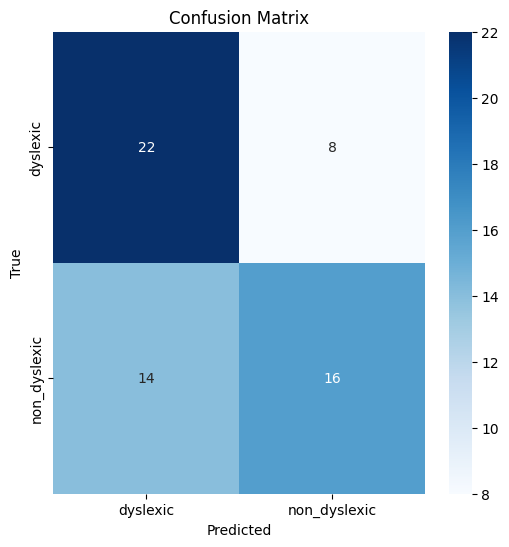

In [ ]:
# Load model dari fold dengan performa terbaik
best_model_rf = joblib.load(os.path.join(rf_results_dir, "random_forest_fold3.joblib"))  # ubah nomor fold

# Preprocess data uji
# Flatten
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
# PCA
pca = PCA(n_components=100)  # Reduce to 100 features
X_train_pca = pca.fit_transform(X_train_flattened)
X_test_pca = pca.transform(X_test_flattened)

# Pengujian model random forest
y_test_pred = best_model_rf.predict(X_test_pca)

# Kalkulasi metrik evaluasi hasil pengujian
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nTest Set Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Plot grafik confusion matrix
plot_confusion_matrix(y_test, y_test_pred, class_names=["dyslexic", "non_dyslexic"])